## Machine learning classification on 5 big cell clusters of a whole brain section

In [1]:
import anndata as ad
import numpy as np
import scanpy as sc
import squidpy as sq
import shap
from sklearn.model_selection import train_test_split

# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import xgboost as xgb

import itertools
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

### Load preprocessed nuclear protein average intensity matrix of a whole brain section
Cells are already clustered to 5 big clusters based on nuclear protein intensities.

In [3]:
adata_ave_int = ad.read_h5ad('all_cells_ave_int_5_leiden.h5ad')

In [119]:
adata_ave_int

AnnData object with n_obs × n_vars = 194724 × 15
    obs: 'cluster', 'leiden', 'leiden0'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial3d'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

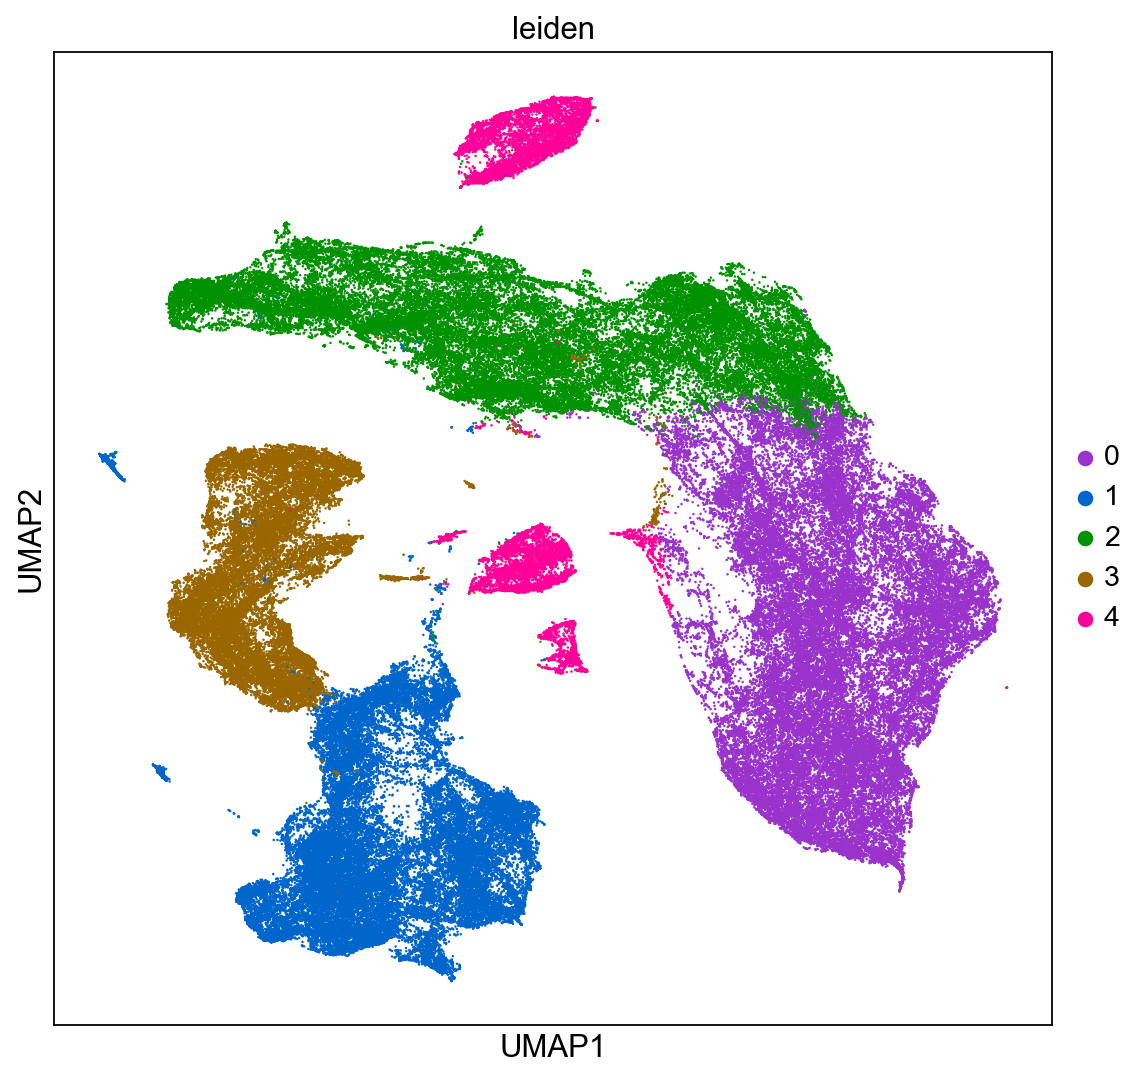

In [115]:
sc.set_figure_params(figsize=(8, 8))

# Create the UMAP plot with customized color

custom_colors = ['#9933cc',  # purple
                 '#0066cc',  # blue
                 '#009200',  # green
                 '#996600',  # brown
                 '#ff0099']  # pink

# Set the color palette
adata_ave_int.uns['leiden_colors'] = custom_colors

# Plot
sc.pl.umap(
    adata_ave_int,
    color=["leiden"],
    size=5,
    show=False
)
# Rasterize all collections (points)
for ax in plt.gcf().axes:
    for coll in ax.collections:
        coll.set_rasterized(True)

# Save as high-quality vector PDF with rasterized scatter points
plt.savefig("./ML_all_numbers_of_proteins/umap_leiden_rasterized.pdf", format="pdf", bbox_inches="tight")

# Optional: show it interactively
plt.show()

In [5]:
# rotate spatial coordinates for plotting the brain section

# Backup original coordinates
original_coords = adata_ave_int.obsm["spatial"].copy()

# Rotate coordinates
theta = np.radians(-137)
rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])
rotated_coords = original_coords @ rotation_matrix.T
adata_ave_int.obsm["spatial"] = rotated_coords

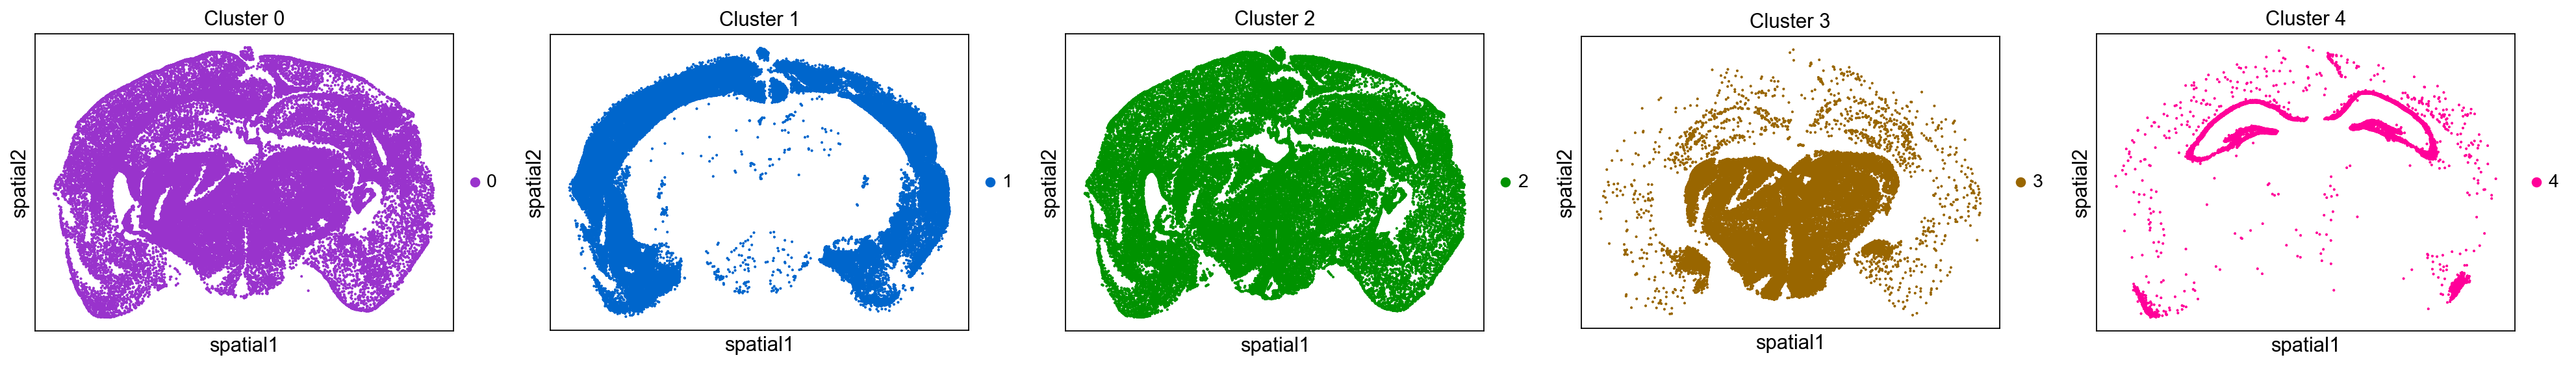

In [117]:
# Plot spatial distributions of the 5 clusters

from matplotlib.backends.backend_pdf import PdfPages
clusters = [str(i) for i in range(0, 5)]  
n_clusters = len(clusters)

ncols = 5
nrows = (n_clusters + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
axes = axes.flatten()

for i, cluster in enumerate(clusters):
    ax = axes[i]
    sq.pl.spatial_scatter(
        adata_ave_int,
        color="leiden",
        groups=[cluster],
        library_id="one",
        size=2,
        shape=None,
        ax=ax,
        title=f"Cluster {cluster}",
        # show=False,
    )

# Hide any extra axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()

pdf_path = "./ML_all_numbers_of_proteins/spatial_clusters.pdf"
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches="tight")  # save current figure
    # optional: add metadata
    d = pdf.infodict()
    
plt.show()
plt.close(fig)

### RNA features of the cell clusters

In [8]:
# Load single-cell RNA cycleHCR data from RNA spot-to-cell assignment
rna_df = pd.read_csv("./cell_by_transcript_gene_name_matrix2.csv", index_col=0)

In [9]:
# Match cell IDs
rna_df.index = rna_df.index.astype(str).str.strip()
common_cells = adata_ave_int.obs_names.intersection(rna_df.index)
rna_df = rna_df.loc[common_cells]
adata_rna = ad.AnnData(
    X=rna_df.to_numpy(),
    obs=adata_ave_int.obs.loc[common_cells].copy(),
    var=pd.DataFrame(index=rna_df.columns.astype(str))
)
adata_rna.obs_names = common_cells
adata_rna.var_names = rna_df.columns.astype(str)

for key in adata_ave_int.obsm.keys():
    adata_rna.obsm[key] = adata_ave_int.obsm[key][adata_ave_int.obs_names.get_indexer(common_cells)]

adata_rna.uns = adata_ave_int.uns.copy()

In [10]:
sc.pp.normalize_total(adata_rna, inplace=True)
sc.pp.log1p(adata_rna)

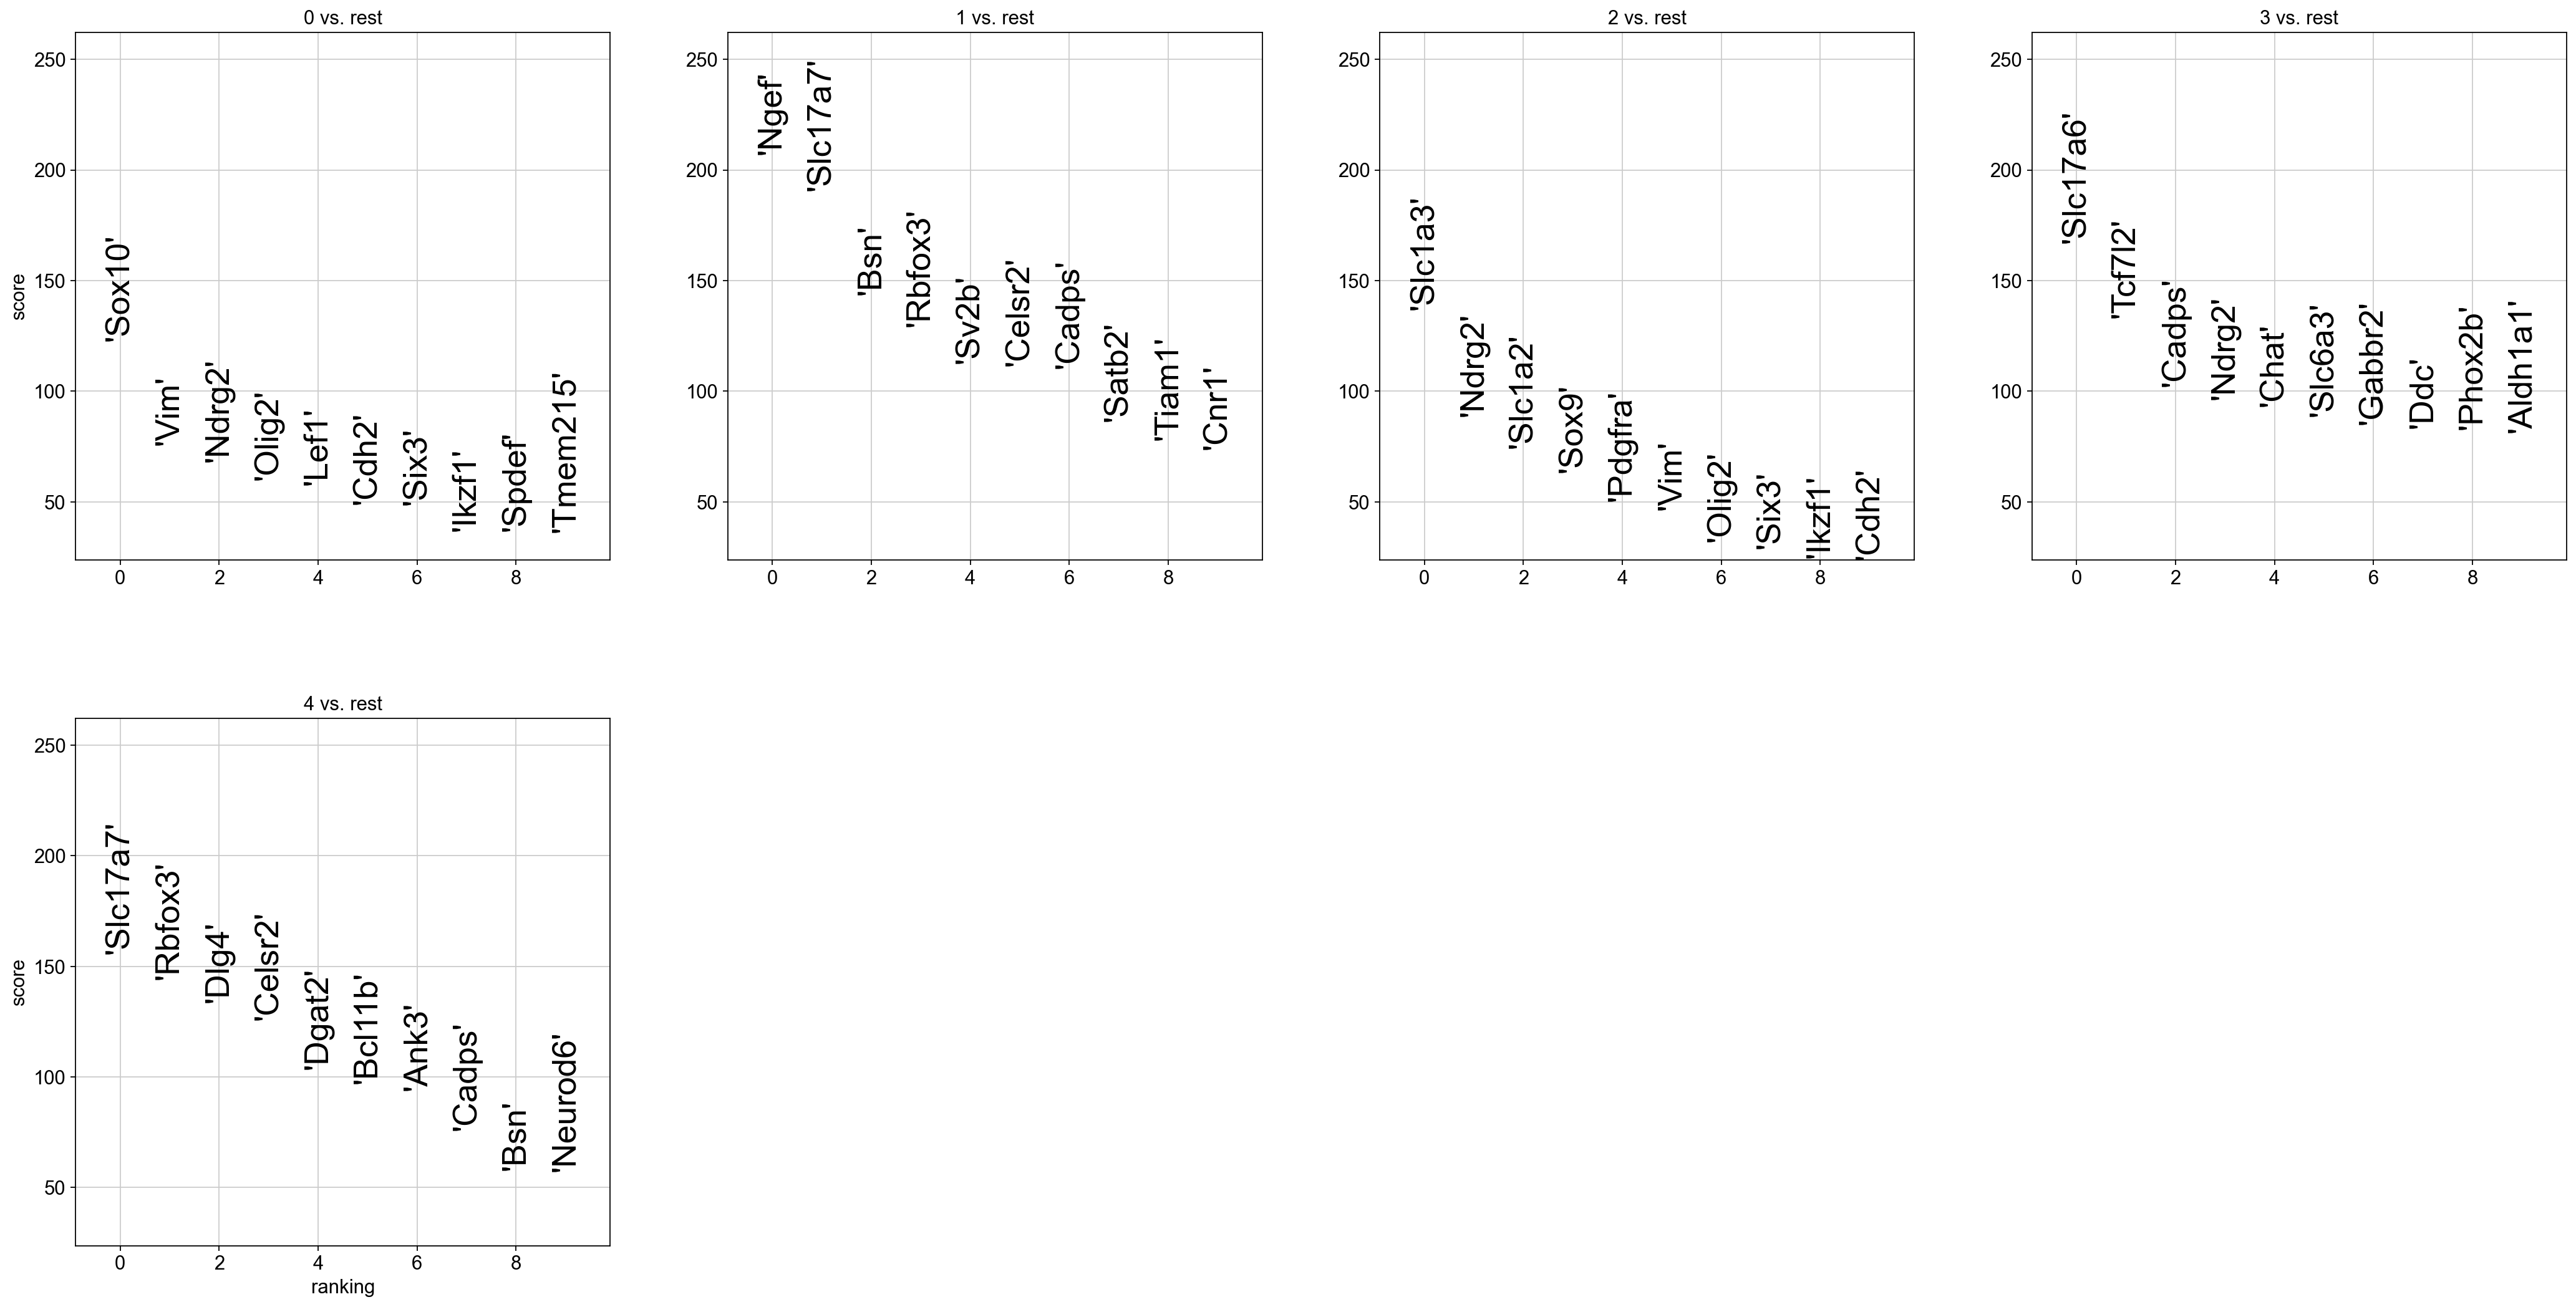

In [11]:
sc.tl.rank_genes_groups(adata_rna, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_rna, n_genes=10, fontsize=24)

Assign cell types for the clusters based on the featured cell-type marker genes shown above

In [13]:
print('''      Cluster 0: Oligo
      Cluster 1: Cortex Neuron
      Cluster 2: Astro-Epen
      Cluster 3: TH-HY Neuron
      cluster 4: HPF Neuron''')

      Cluster 0: Oligo
      Cluster 1: Cortex Neuron
      Cluster 2: Astro-Epen
      Cluster 3: TH-HY Neuron
      cluster 4: HPF Neuron


## XGBoost classification using varying numbers of nulcear proteins

In [16]:
# Total number of nuclear proteins in matrix
protein_markers = adata_ave_int.var_names
len(protein_markers)

15

In [26]:
# prepare data for training classification model
X = adata_ave_int.X
if not isinstance(X, np.ndarray):
    X = X.toarray()   # convert sparse matrix if needed

leiden_cat = adata_ave_int.obs["leiden"].astype("category")
y = leiden_cat.cat.codes
leiden_mapping = dict(enumerate(leiden_cat.cat.categories))

In [ ]:
# build dataframes to store classification metrics
all_metrics_df = pd.DataFrame()       # detailed metrics for each marker combination
summary_stats_df = pd.DataFrame()     # mean ± sd summary per num_proteins

outdir = "./ML_numbers_of_proteins/num_proteins_csv"
os.makedirs(outdir, exist_ok=True)

# Loop through different protein set sizes (3 to 15)
for num_proteins in range(3, 16):
    print(f"Training models with {num_proteins} protein markers...")

    metrics_df = pd.DataFrame()

    # Generate all possible num_proteins-combinations with the current number of proteins
    for selected_markers in itertools.combinations(protein_markers, num_proteins):
        selected_markers = set(selected_markers)  # Convert to set for lookup
        marker_name = '-'.join(sorted(selected_markers))  # Row name with protein combinations
        # print(f"\nSelected Proteins: {selected_markers}")

        # Select correlation columns matching the chosen proteins
        marker_indices = [list(protein_markers).index(col) for col in selected_markers]
        X_subset = X[:, marker_indices]

        # Split into training & testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42, stratify=y)

        # Train XGBoost model
        xgb_model = xgb.XGBClassifier(
            n_estimators=500,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            eval_metric="mlogloss"
        )
        xgb_model.fit(X_train, y_train)
        
        y_pred = xgb_model.predict(X_test)
        y_pred_proba = xgb_model.predict_proba(X_test)

        # Compute classification report
        report = classification_report(y_test, y_pred, output_dict=True)

        # Compute macro-average ROC AUC
        try:
            auc_macro = roc_auc_score(
                y_test, y_pred_proba, multi_class="ovr", average="macro"
            )
        except Exception as e:
            auc_macro = None
            print(f"⚠️ ROC AUC could not be calculated: {e}")

        # Store metrics
        row_metrics = {
            "num_proteins": num_proteins,
            "accuracy": report["accuracy"],
            "auc_macro": auc_macro
        }

        # Add per-class metrics (precision, recall, f1 score for each of the 5 cell types)
        for cell_type in report.keys():
            if cell_type not in ["accuracy", "macro avg", "weighted avg"]:
                row_metrics[f"precision_{cell_type}"] = report[cell_type]["precision"]
                row_metrics[f"recall_{cell_type}"] = report[cell_type]["recall"]
                row_metrics[f"f1_{cell_type}"] = report[cell_type]["f1-score"]

        # print(row_metrics)

        # Add this row to the results dataframe
        metrics_df = pd.concat([metrics_df, pd.DataFrame(row_metrics, index=[marker_name])])

    filename = os.path.join(outdir, f"all_neurons_ave_int_{num_proteins}_proteins.csv")
    metrics_df.to_csv(filename)

    # Append detailed results to global dataframe
    all_metrics_df = pd.concat([all_metrics_df, metrics_df])

    # mean ± sd summary per num_proteins
    summary_row = metrics_df.mean().to_dict()
    summary_row_sd = metrics_df.std().to_dict()
    
    summary_data = {}
    for col in metrics_df.columns:
        summary_data[f"{col}_mean"] = summary_row[col]
        summary_data[f"{col}_sd"] = summary_row_sd[col]
    
    # Add the num_proteins identifier
    summary_data["num_proteins"] = num_proteins
    
    # Append to summary stats dataframe
    summary_stats_df = pd.concat([summary_stats_df, pd.DataFrame([summary_data])], ignore_index=True)

# Training all combinations takes a while. 
# Save detailed results and summary statistics when completed.
all_metrics_df.to_csv("./ML_all_numbers_of_proteins/all_results_detailed.csv")
summary_stats_df.to_csv("./ML_all_numbers_of_proteins/summary_statistics.csv")
print(f"✅ Saved all per-protein CSVs and combined summary at {outdir}")

In [28]:
# Load saved classification metrics
summary_stats_df = pd.read_csv("./ML_all_numbers_of_proteins/summary_statistics.csv")

In [30]:
# Calculate average F1 scores using F1 scores of each class

# Select the F1 mean columns
f1_mean_cols = [col for col in summary_stats_df.columns if col.startswith("f1_") and col.endswith("_mean")]

# Compute the average F1 across those columns for each row
summary_stats_df["macro_avg_f1_mean"] = summary_stats_df[f1_mean_cols].mean(axis=1)

# (Optional) Compute the average SD across the same F1 columns
f1_sd_cols = [col for col in summary_stats_df.columns if col.startswith("f1_") and col.endswith("_sd")]
summary_stats_df["macro_avg_f1_sd"] = summary_stats_df[f1_sd_cols].mean(axis=1)

# Display the new columns
# print(summary_stats_df[["num_proteins_mean", "macro_avg_f1_mean", "macro_avg_f1_sd"]])

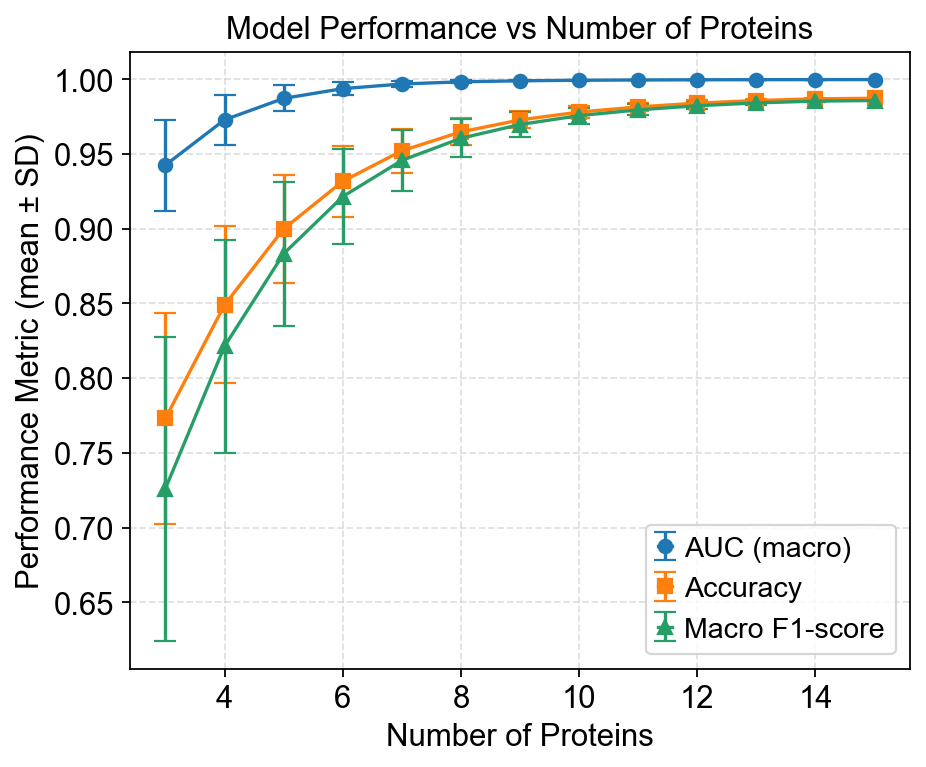

In [65]:
# Plot overall performance of classification using different numbers of proteins
plt.figure(figsize=(6, 5))

# AUC (mean ± SD)
plt.errorbar(
    summary_stats_df["num_proteins_mean"],
    summary_stats_df["auc_macro_mean"],
    yerr=summary_stats_df["auc_macro_sd"],
    fmt="-o",
    capsize=5,
    label="AUC (macro)"
)

# Accuracy (mean ± SD)
plt.errorbar(
    summary_stats_df["num_proteins_mean"],
    summary_stats_df["accuracy_mean"],
    yerr=summary_stats_df["accuracy_sd"],
    fmt="-s",
    capsize=5,
    label="Accuracy"
)

# Macro F1-score (mean ± SD)
plt.errorbar(
    summary_stats_df["num_proteins_mean"],
    summary_stats_df["macro_avg_f1_mean"],
    yerr=summary_stats_df["macro_avg_f1_sd"],
    fmt="-^",
    capsize=5,
    label="Macro F1-score"
)

# Labels and formatting
plt.xlabel("Number of Proteins")
plt.ylabel("Performance Metric (mean ± SD)")
plt.title("Model Performance vs Number of Proteins")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

plt.savefig("./ML_all_numbers_of_proteins/classification_Num_proteins.pdf", dpi=300)
plt.show()

## Rank the importance of 15 nuclear proteins for classification

In [35]:
# 1. Extract data
# X = features, y = cluster labels
X = adata_ave_int.X
if not isinstance(X, np.ndarray):
    X = X.toarray()   # convert sparse matrix if needed

leiden_cat = adata_ave_int.obs["leiden"].astype("category")
y = leiden_cat.cat.codes

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [37]:
## XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     16471
           1       0.99      0.99      0.99     14530
           2       0.99      0.99      0.99     14033
           3       0.98      0.98      0.98      8824
           4       0.98      0.98      0.98      4560

    accuracy                           0.99     58418
   macro avg       0.99      0.99      0.99     58418
weighted avg       0.99      0.99      0.99     58418

Accuracy: 0.9874182614947448


In [69]:
# Use SHAP values to explain XGBoost tree-based classification model

explainer_xgb = shap.TreeExplainer(xgb_model)
explanation_xgb = explainer_xgb(X_test)

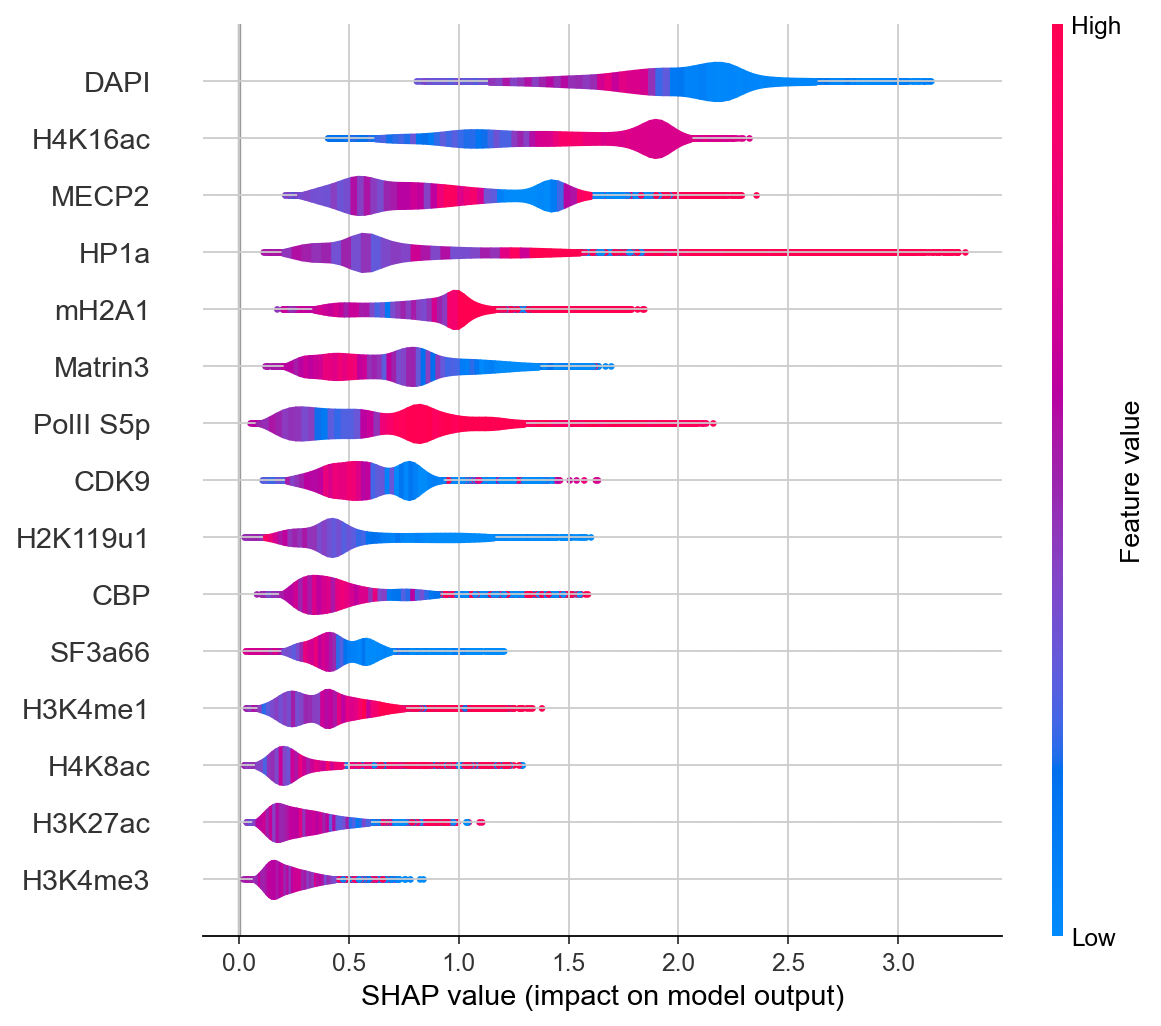

In [39]:
explanation_global = np.abs(explanation_xgb.values).mean(axis=2)

# build a new Explanation object so violin works
explanation_global = shap.Explanation(
    values=explanation_global,
    base_values=explanation_xgb.base_values.mean(1),
    data=explanation_xgb.data,
    feature_names=adata_ave_int.var_names
)

# Overall feature importance violin plot
shap.plots.violin(explanation_global)

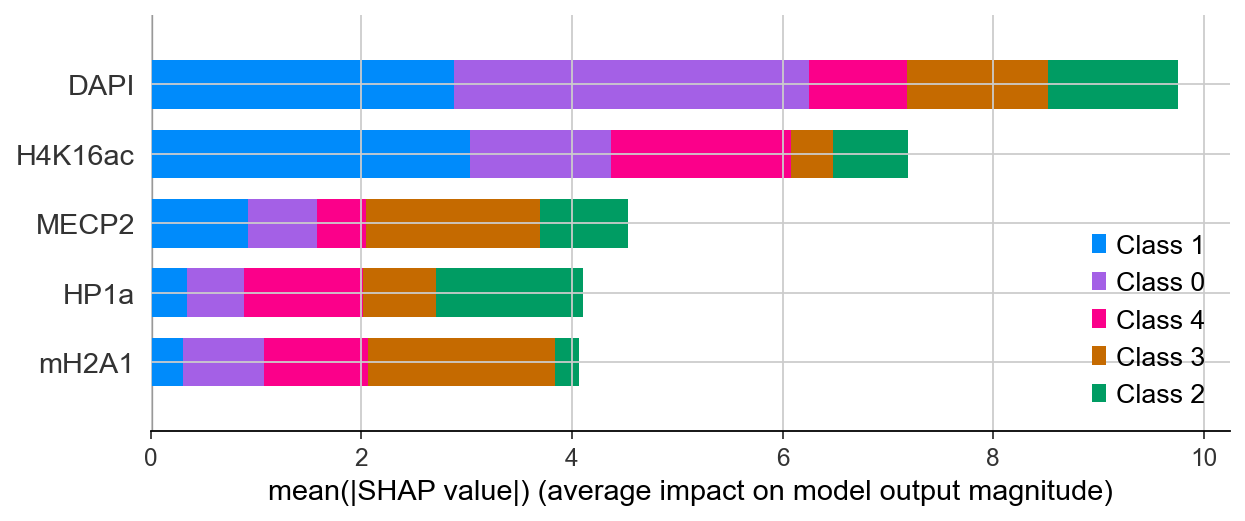

In [103]:
# Plot overall feature importance
# mean absolute SHAP values for each class are shown

shap.summary_plot(
    explanation_xgb,
    feature_names=adata_ave_int.var_names,
    max_display=5,                          # only show the top 5 features
    show=False  # prevent automatic display
)

# Get current figure and save
plt.gcf().savefig(
    "./ML_all_numbers_of_proteins/shap_bar.eps",
    format="eps",
    dpi=300,
    bbox_inches="tight"
)

# Optional: display interactively
plt.show()

# Close figure to free memory
plt.close()

## Separate feature importance plots for each class
The key proteins contributing to classification vary between cell classes.

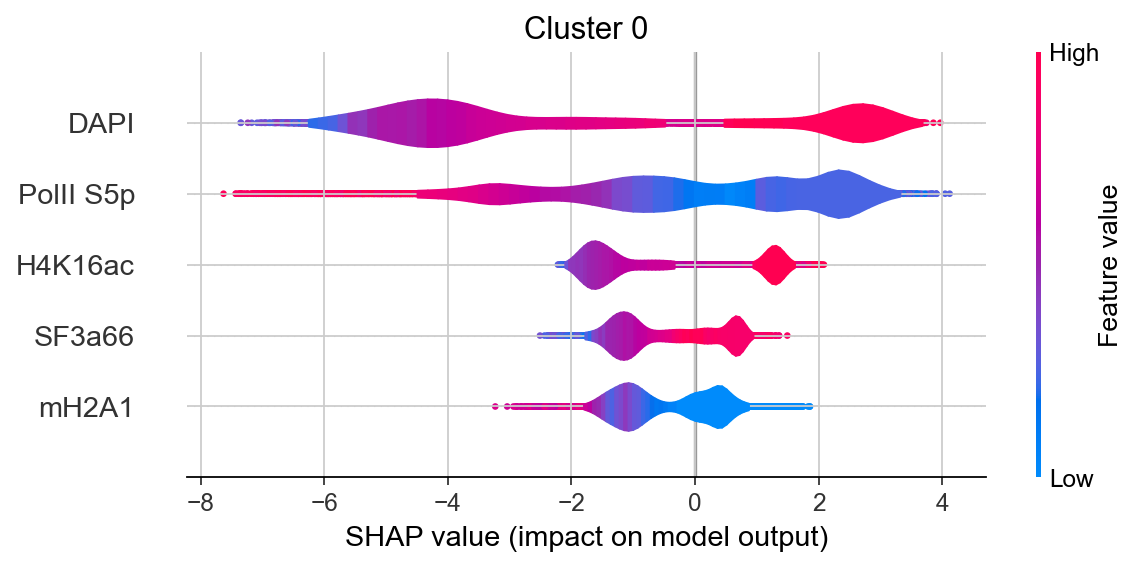

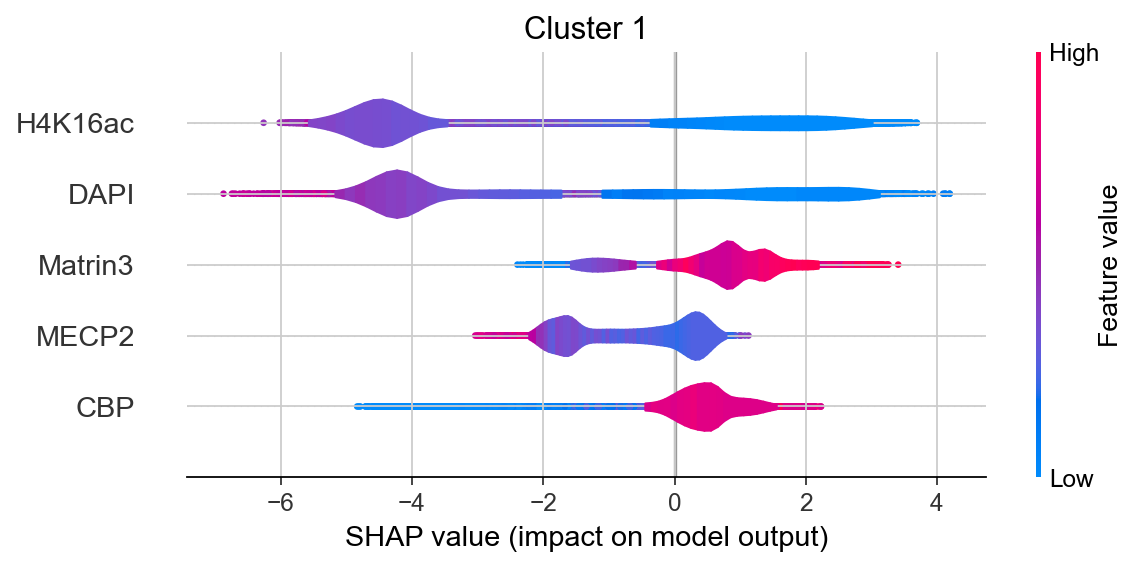

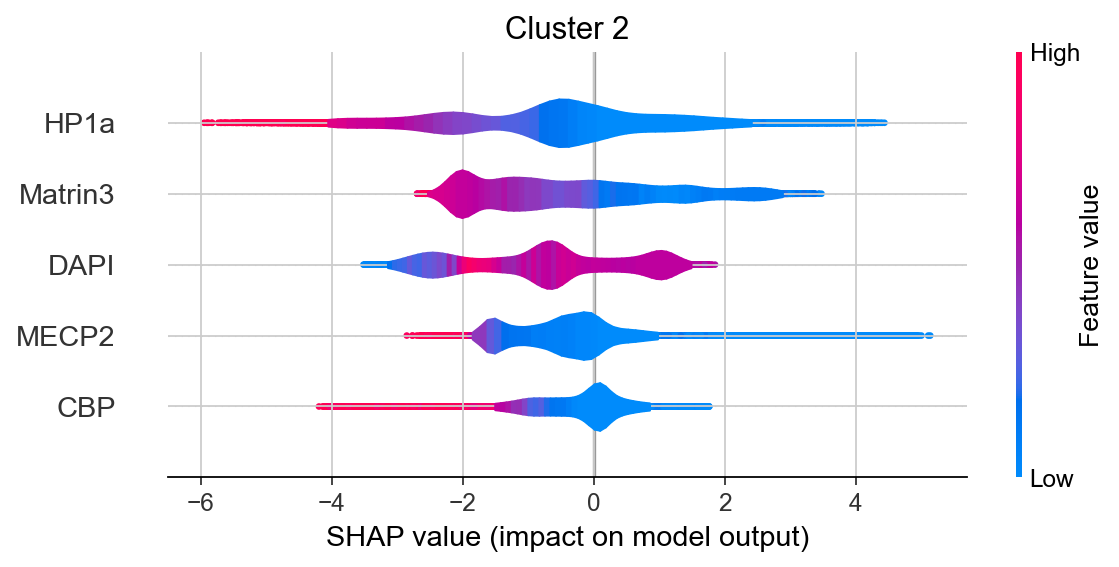

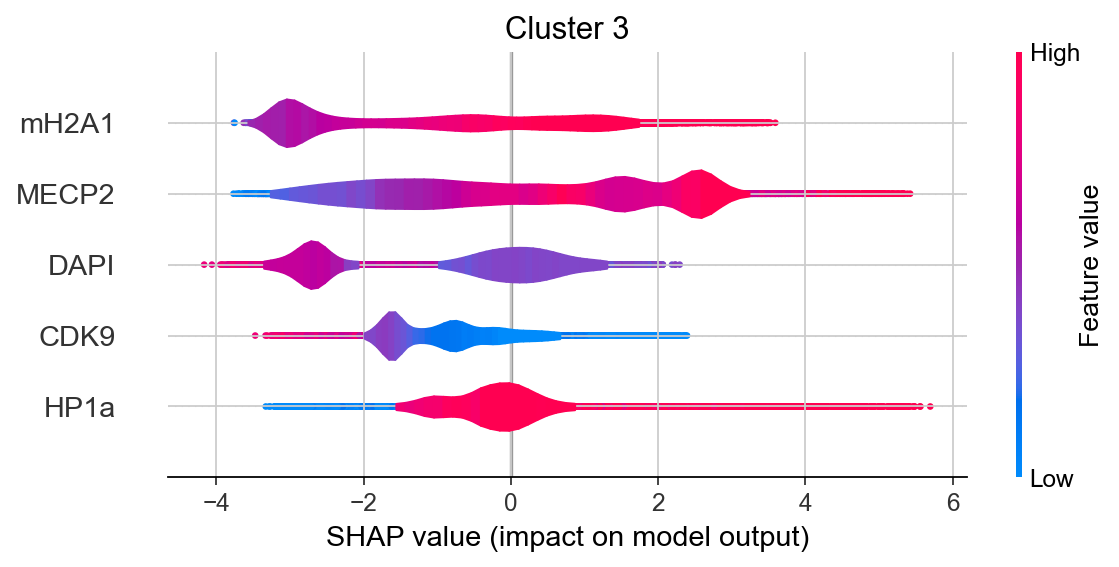

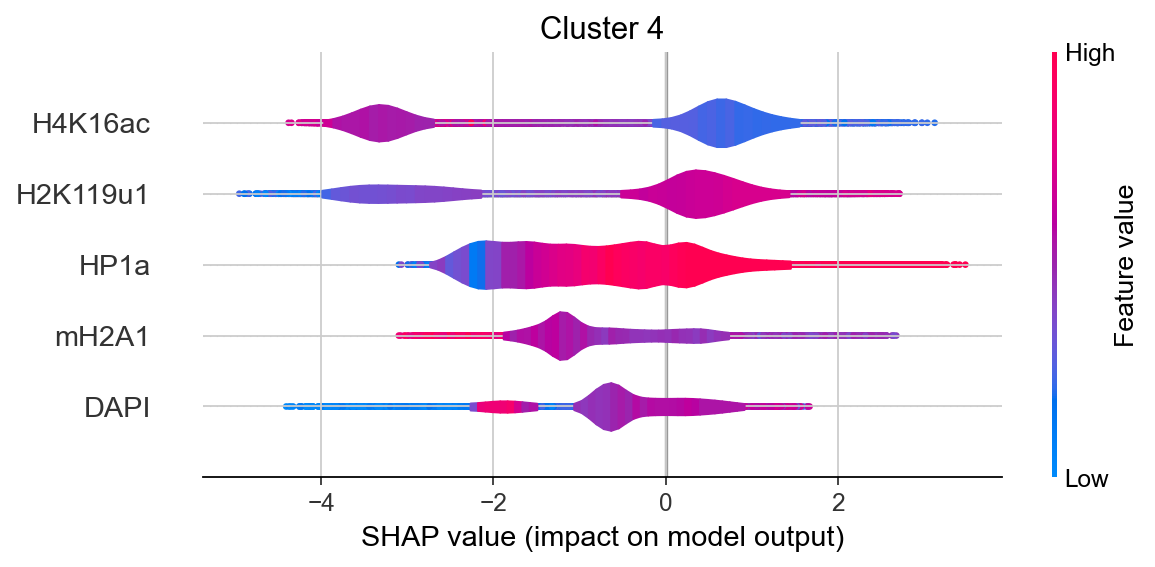

In [87]:
# save plots of the top 5 features

for i in range(explanation_xgb.values.shape[2]):
    # Create the SHAP violin plot without showing it
    shap.plots.violin(
        explanation_xgb[:, :, i],
        feature_names=adata_ave_int.var_names,
        max_display=5,                              # only show top 5 features
        show=False
    )
    plt.title(f"Cluster {i}")

    # Rasterize all collections (points/violins) to reduce EPS size
    for ax in plt.gcf().axes:
        for coll in ax.collections:
            coll.set_rasterized(True)

    # Save rasterized EPS
    plt.savefig(
        f"./ML_all_numbers_of_proteins/shap_violin_cluster_{i}.pdf",
        dpi=300,
        bbox_inches="tight"
    )

    # Optional: show interactively
    plt.show()

    # Close figure to free memory
    plt.close()